In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp -r /content/drive/MyDrive/Epilepsy /content/

^C


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms,datasets
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import os
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cuda


In [16]:
num_epochs=10
batch_size=32

In [5]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((224,224)),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
dataset=datasets.ImageFolder('/content/Epilepsy',transform=transform)

In [6]:
print(len(dataset))

2493


In [7]:
train_dataset, test_dataset = random_split(dataset,[1594,899])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
val_dataset,test_dataset=random_split(test_dataset,[400,499])
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Model 1

In [17]:
model=torchvision.models.resnet18(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [18]:
model = model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adamax(model.parameters())

In [19]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
num_classes = 2
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [21]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
#training loop
train_loss_f=[]
val_loss_f=[]
n_total_steps=len(train_loader)
for epoch in range(num_epochs):#iterate over epochs and inside each epoch iterate over batches
    #train_loader is an iterable but we use enumerate to keep track of index of each element of iterable
    train_loss=[]
    val_loss=[]
    for i,(images,labels) in enumerate(train_loader):
        images=images.to(device)#.to(device) returns a copy of the tensor that is now on GPU
        labels=labels.to(device)
        #labels=labels.unsqueeze(1)#to increase dimension of target to match predictions
        #forward pass
        outputs=model(images)
        loss=criterion(outputs,labels)
        #backward pass
        optimizer.zero_grad()#always zero out the gradients in each step
        loss.backward()
        #for name, param in model.named_parameters():
            #print(name, param.grad)
        #update parameters
        optimizer.step()
        if (i+1)%25==0:
            print(f'Epoch:{epoch+1}/{num_epochs}, Step:{i+1}/{n_total_steps}, Loss={loss.item():.4f}')
        train_loss.append(loss.item())
    train_loss_f.append(np.mean(train_loss))
    with torch.no_grad():
      for i,(images,labels) in enumerate(val_loader):
          images=images.to(device)#.to(device) returns a copy of the tensor that is now on GPU
          labels=labels.to(device)
          #labels=labels.unsqueeze(1)#to increase dimension of target to match predictions
          #forward pass
          outputs=model(images)
          loss=criterion(outputs,labels)
          #backward pass
          #optimizer.zero_grad()#always zero out the gradients in each step
          #loss.backward()
          #for name, param in model.named_parameters():
              #print(name, param.grad)
          #update parameters
          #optimizer.step()
          if (i+1)%10==0:
              print(f'Epoch:{epoch+1}/{num_epochs}, Step:{i+1}/{n_total_steps}, Loss={loss.item():.4f}')
          val_loss.append(loss.item())
      val_loss_f.append(np.mean(val_loss))
print("Finished training")

Epoch:1/10, Step:25/50, Loss=0.2051
Epoch:1/10, Step:50/50, Loss=0.2627
Epoch:1/10, Step:10/50, Loss=0.0680
Epoch:2/10, Step:25/50, Loss=0.2822
Epoch:2/10, Step:50/50, Loss=0.1475
Epoch:2/10, Step:10/50, Loss=0.1481
Epoch:3/10, Step:25/50, Loss=0.0931
Epoch:3/10, Step:50/50, Loss=0.1436
Epoch:3/10, Step:10/50, Loss=0.0363
Epoch:4/10, Step:25/50, Loss=0.1514
Epoch:4/10, Step:50/50, Loss=0.0332
Epoch:4/10, Step:10/50, Loss=0.0191
Epoch:5/10, Step:25/50, Loss=0.0814
Epoch:5/10, Step:50/50, Loss=0.0552
Epoch:5/10, Step:10/50, Loss=0.2234
Epoch:6/10, Step:25/50, Loss=0.1406
Epoch:6/10, Step:50/50, Loss=0.0994
Epoch:6/10, Step:10/50, Loss=0.0244
Epoch:7/10, Step:25/50, Loss=0.1051
Epoch:7/10, Step:50/50, Loss=0.0745
Epoch:7/10, Step:10/50, Loss=0.0819
Epoch:8/10, Step:25/50, Loss=0.0986
Epoch:8/10, Step:50/50, Loss=0.0480
Epoch:8/10, Step:10/50, Loss=0.0140
Epoch:9/10, Step:25/50, Loss=0.3570
Epoch:9/10, Step:50/50, Loss=0.0121
Epoch:9/10, Step:10/50, Loss=0.2590
Epoch:10/10, Step:25/50, Los

In [23]:
t=[]
p=[]
l=[]
for i,(images,labels) in enumerate(test_loader):
  images=images.to(device)#.to(device) returns a copy of the tensor that is now on GPU
  labels=labels.to(device)
  t.append(labels)
  #labels=labels.unsqueeze(1)#to increase dimensio
  #n of target to match predictions
  #forward pass
  outputs=model(images)
  p.append(outputs)
  loss=criterion(outputs,labels)
  l.append(loss.item())

In [24]:
pred = []

# Loop through each tensor in the list
for tensor in p:
    # Move the tensor to CPU if it's on GPU
    tensor_cpu = tensor.cpu()

    # Find the indices of the maximum values along the second dimension
    max_indices = torch.argmax(tensor_cpu, dim=1)

    # Append the flattened indices to the list
    pred.extend(max_indices.flatten().tolist())

print(pred)

[1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 

In [25]:
true = []

# Loop through each tensor in the list
for tensor in p:
    # Move the tensor to CPU if it's on GPU
    tensor_cpu = tensor.cpu()

    # Find the indices of the maximum values along the second dimension
    max_indices = torch.argmax(tensor_cpu, dim=1)

    # Append the flattened indices to the list
    true.extend(max_indices.flatten().tolist())

print(true)

[1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 

In [26]:
len(pred)

499

In [27]:
from sklearn.metrics import classification_report
print("Classification report\n",classification_report(true,pred))

Classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       256
           1       1.00      1.00      1.00       243

    accuracy                           1.00       499
   macro avg       1.00      1.00      1.00       499
weighted avg       1.00      1.00      1.00       499



In [28]:
train_loss_f

[0.3716415100544691,
 0.2007504691183567,
 0.1095006092544645,
 0.12246787300333381,
 0.11220954082906247,
 0.12310282533988356,
 0.08114118348341436,
 0.0776266265194863,
 0.06998602613806724,
 0.10120029900223017]

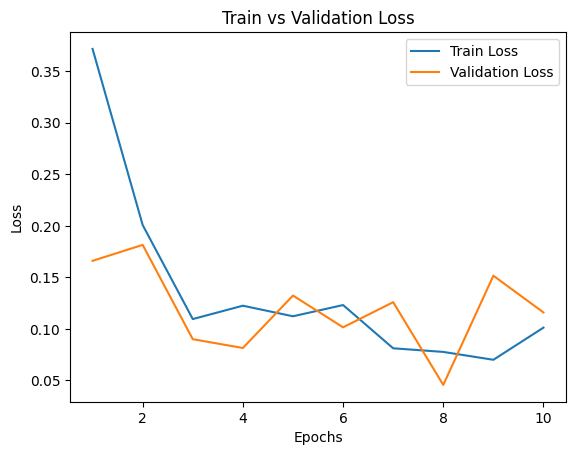

In [29]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_f) + 1)

plt.plot(epochs, train_loss_f, label='Train Loss')
plt.plot(epochs, val_loss_f, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

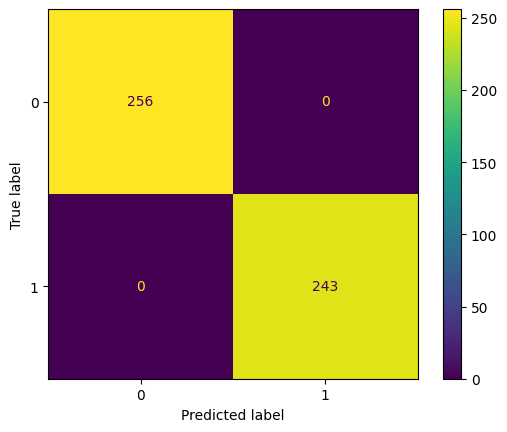

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [31]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('Resnet_adam_notpretarined_10e_1f.pt')